<a href="https://colab.research.google.com/github/sdf-works/sam-learns-ML/blob/main/pinn_heat_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Physics-Informed Neural Network (PINN) — 1D Heat Equation

🚧 This is a work-in-progress notebook! I'm exploring how to apply PINNs to solve PDEs like the heat equation using PyTorch.

---

## 🔧 Goal
Build a simple PINN to solve the 1D heat equation:
∂u/∂t = D ∂²u/∂x²

---

## 📚 Outline

- [ ] Define the PDE and domain
- [ ] Create the NN architecture
- [ ] Use autograd to compute physics residuals
- [ ] Set up loss: data + physics
- [ ] Train and visualize results

📌 It's not here *yet*, but it's on my radar. I’m leaving this in the repo so you know I’m thinking about how to build and understand PINNs from first principles — especially how to train models that respect physical laws in data-sparse environments.


# 🔥 Solving the 1D Heat Equation with a Physics-Informed Neural Network (PINN)

We’re using a PINN to solve the classic 1D **heat equation**, which describes how heat diffuses over time:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

Where:
- $( u(x, t) $): temperature at position $( x )$ and time $( t )$
- $( \alpha )$: thermal diffusivity (we’ll set $( \alpha = 1 )$ for simplicity)

### 📏 Domain

$$
x \in [0, 1], \quad t \in [0, 1]
$$

### 🧱 Conditions

- **Initial condition**: $( u(x, 0) = \sin(\pi x) )$
- **Boundary conditions**: $( u(0, t) = u(1, t) = 0 )$

---

### 🎯 Goal

Train a neural network $( \hat{u}(x, t; \theta) )$ to approximate the solution by minimizing:

1. Loss on initial & boundary conditions
2. The residual of the heat equation itself (so it obeys physics!)

This is a gentle intro to PINNs — no mesh, no PDE solver — just gradients and a good brain.

In [57]:
#libraries

import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# Set manual seed for reproducibility
torch.manual_seed(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
#device check
# Print result
print("🖥️ Using device:", device)

# Extra info if CUDA is available
if device.type == "cuda":
    print("🔋 CUDA device name:", torch.cuda.get_device_name(0))
    print("🔥 CUDA memory allocated (MB):", torch.cuda.memory_allocated(0) / 1024**2)
    print("🚀 CUDA memory reserved  (MB):", torch.cuda.memory_reserved(0) / 1024**2)

🖥️ Using device: cpu


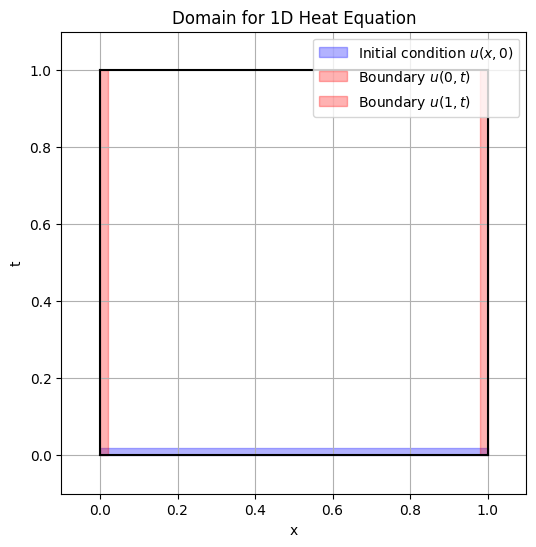

In [59]:
#start by visualizing the domain

fig, ax = plt.subplots(figsize=(6, 6))

# Draw domain box
ax.plot([0, 1], [0, 0], 'k')  # bottom
ax.plot([0, 1], [1, 1], 'k')  # top
ax.plot([0, 0], [0, 1], 'k')  # left
ax.plot([1, 1], [0, 1], 'k')  # right

# Shade initial condition region (t ≈ 0)
ax.fill_between([0, 1], 0, 0.02, color='blue', alpha=0.3, label='Initial condition $u(x, 0)$')

# Shade boundary condition regions (x ≈ 0 and x ≈ 1)
ax.fill_betweenx([0, 1], 0, 0.02, color='red', alpha=0.3, label='Boundary $u(0,t)$')
ax.fill_betweenx([0, 1], 0.98, 1.0, color='red', alpha=0.3, label='Boundary $u(1,t)$')

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Domain for 1D Heat Equation")
ax.legend(loc="upper right")
ax.grid(True)

plt.show()

In [60]:
#generate data
# Define domain
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

#initial condition
# Generate initial condition data (t = 0)
N_0 = 100  # Number of points for initial condition
x_0 = np.linspace(0, 1, N_0).reshape(-1, 1)  # x values at t = 0
t_0 = np.zeros_like(x_0)                    # All t = 0
u_0 = np.sin(np.pi * x_0)                   # u(x, 0) = sin(πx), exact initial condition

#Convert to tensors
x_0_tensor = torch.tensor(x_0, dtype=torch.float32)
t_0_tensor = torch.tensor(t_0, dtype=torch.float32)
u_0_tensor = torch.tensor(u_0, dtype=torch.float32)

#Stack and send to device
X_0 = torch.cat([x_0_tensor, t_0_tensor], dim=1).to(device)  # shape [N_0, 2]
Y_0 = u_0_tensor.to(device)                                  # shape [N_0, 1]

#boundary condition
N_b = 100  # Number of boundary points
t_b = np.random.rand(N_b, 1)  # Random time samples in [0, 1)

x_lb = np.zeros_like(t_b)     # x = 0 (left boundary)
x_ub = np.ones_like(t_b)      # x = 1 (right boundary)

u_lb = np.zeros_like(t_b)     # u(0, t) = 0
u_ub = np.zeros_like(t_b)     # u(1, t) = 0

#turn into arrays
X_lb = np.hstack([x_lb, t_b])  # (x = 0, t)
X_ub = np.hstack([x_ub, t_b])  # (x = 1, t)
X_b = np.vstack([X_lb, X_ub])  # Combine both sides

Y_b = np.vstack([u_lb, u_ub])  # All boundary values are zero

#convert to tensors
X_b = torch.tensor(X_b, dtype=torch.float32).to(device)
Y_b = torch.tensor(Y_b, dtype=torch.float32).to(device)

#colocation points
# Number of colocation points
N_f = 10_000

# Randomly sample x and t in the domain (0,1)
x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)

# Stack them into (x, t) pairs
X_f = np.hstack([x_f, t_f])

# Convert to PyTorch tensor and move to device
X_f = torch.tensor(X_f, dtype=torch.float32).to(device)

## ⚙️ What Are Colocation Points in a PINN?

Colocation points are **locations in the domain where we don't have data**, but we **do** know the physics.

At these points, the model is trained to satisfy the **governing differential equation**, rather than matching data values.

---

### 🔍 What's Happening?

At colocation points:
- The model outputs a prediction $ u(x, t) $
- We use **autograd** to compute:
  - $\frac{\partial u}{\partial t}$
  - $\frac{\partial^2 u}{\partial x^2} $
- We check how well the model satisfies the PDE:
  
  $$
  \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} = 0
  $$

---

### 📉 The Physics Loss

We define a loss term that penalizes the model when it violates the physics:

$$
\text{Loss}_{\text{physics}} = \text{MSE}\left( \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2},\ 0 \right)
$$

---

### 🧠 Summary:

| Data Type            | How it's used                           |
|----------------------|-----------------------------------------|
| Initial Condition    | Compare model to known $ u(x, 0) $    |
| Boundary Condition   | Compare model to known $ u(0, t), u(1, t) $ |
| **Colocation Points**| Check that PDE is satisfied             |

Physics-Informed Neural Networks (PINNs) = Data ✚ Derivatives ✚ Physics

In [61]:
#define PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # input: (x, t)
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)   # output: u(x, t)
        )

    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

In [62]:
#loss function

#define NN output
def model_u(x, t):
    X = torch.cat([x, t], dim=1)
    return model(X)

#define physics residual
def physics_residual(x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model_u(x, t)

    # First derivative wrt t
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              retain_graph=True, create_graph=True)[0]

    # First derivative wrt x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                              retain_graph=True, create_graph=True)[0]

    # Second derivative wrt x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                               retain_graph=True, create_graph=True)[0]

    return u_t - u_xx  # Heat equation residual

#total loss function
def pinn_loss(X_0, Y_0, X_b, Y_b, X_f):
    # Initial condition loss
    u_0_pred = model(X_0)
    mse_0 = torch.mean((u_0_pred - Y_0)**2)

    # Boundary condition loss
    u_b_pred = model(X_b)
    mse_b = torch.mean((u_b_pred - Y_b)**2)

    # Physics constraint loss
    x_f = X_f[:, [0]]
    t_f = X_f[:, [1]]
    f_pred = physics_residual(x_f, t_f)
    mse_f = torch.mean(f_pred**2)

    return mse_0 + mse_b + mse_f, mse_0, mse_b, mse_f #loss = MSE(data_fit) + MSE(boundary_fit) + MSE(physics_residual)


In [63]:
#define optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #tracks both mean and variance

In [64]:
#training loop

num_epochs = 500
mse_loss = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # 1. Predict at initial, boundary, and collocation points
    X_f.requires_grad_(True)            # Make sure gradients flow from input
    u_0_pred = model(X_0)                # Initial condition
    u_b_pred = model(X_b)                # Boundary condition
    u_f_pred = model(X_f)                # Collocation points

    # 2. Compute physics residual using autograd
    u_f_pred.requires_grad_(True)
    grads = torch.autograd.grad(
        u_f_pred, X_f,
        grad_outputs=torch.ones_like(u_f_pred),
        create_graph=True, retain_graph=True
    )[0] #taking the first (and only) element — the gradient with respect to X_f

    u_t = grads[:, 1:2] # ∂u/∂t (column 1)
    u_x = grads[:, 0:1] # ∂u/∂x (column 0)
    u_xx = torch.autograd.grad( #second derivative
        u_x, X_f,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True, retain_graph=True
    )[0][:, 0:1]

    residual = u_t - u_xx  # This is from the heat equation: u_t = u_xx, residual needs to be zero

    # 3. Compute total loss
    loss_ic = mse_loss(u_0_pred, Y_0)
    loss_bc = mse_loss(u_b_pred, Y_b)
    loss_phys = mse_loss(residual, torch.zeros_like(residual))

    loss = loss_ic + loss_bc + loss_phys #combines all three losses

    # 4. Backpropagation and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 5. Logging
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f} | IC: {loss_ic.item():.6f}, BC: {loss_bc.item():.6f}, Physics: {loss_phys.item():.6f}")

Epoch 0: Loss = 0.593973 | IC: 0.472207, BC: 0.037882, Physics: 0.083884
Epoch 100: Loss = 0.141726 | IC: 0.086779, BC: 0.050972, Physics: 0.003975
Epoch 200: Loss = 0.112268 | IC: 0.069637, BC: 0.040034, Physics: 0.002597
Epoch 300: Loss = 0.066232 | IC: 0.042903, BC: 0.018376, Physics: 0.004952
Epoch 400: Loss = 0.029240 | IC: 0.018339, BC: 0.006013, Physics: 0.004888
Epoch 499: Loss = 0.016199 | IC: 0.008736, BC: 0.003739, Physics: 0.003723


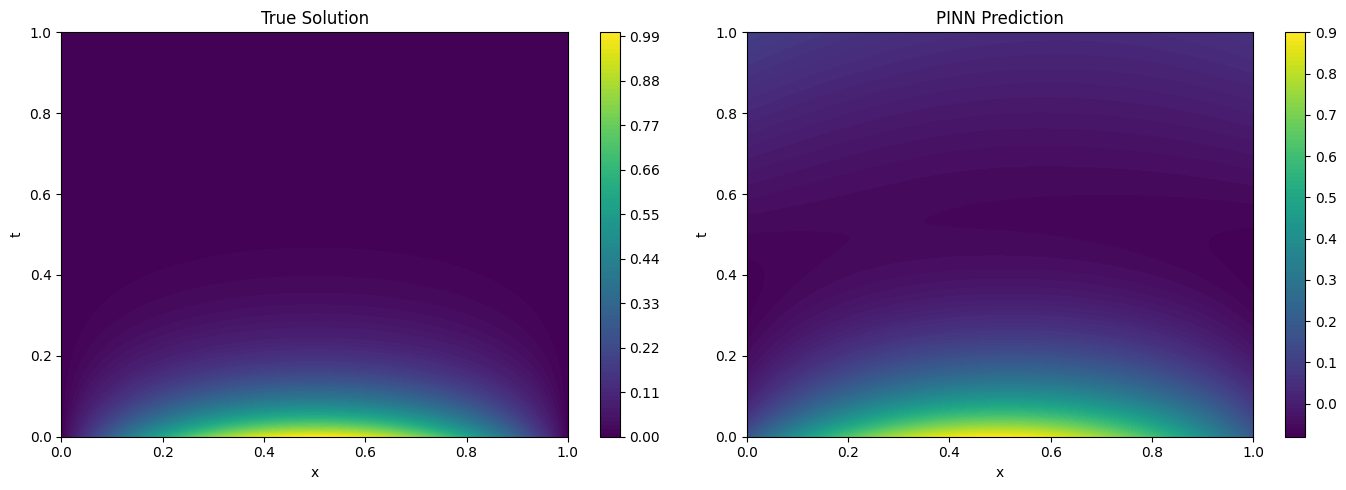

In [65]:
#plot predicted vs true solution

# 1. Create grid of points in (x, t)
x_plot = np.linspace(0, 1, 100)
t_plot = np.linspace(0, 1, 100)
X_plot, T_plot = np.meshgrid(x_plot, t_plot)
X_flat = X_plot.flatten()[:, None]
T_flat = T_plot.flatten()[:, None]
XT_tensor = torch.tensor(np.hstack((X_flat, T_flat)), dtype=torch.float32).to(device)

# 2. Predict with model
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy()

# 3. True solution
u_true = np.sin(np.pi * X_flat) * np.exp(-np.pi**2 * T_flat)

# 4. Reshape for plotting
U_pred = u_pred.reshape(100, 100)
U_true = u_true.reshape(100, 100)

# 5. Plot predicted vs true
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
cf1 = axs[0].contourf(X_plot, T_plot, U_true, 100, cmap='viridis')
axs[0].set_title("True Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(cf1, ax=axs[0])

cf2 = axs[1].contourf(X_plot, T_plot, U_pred, 100, cmap='viridis')
axs[1].set_title("PINN Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
fig.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.show()


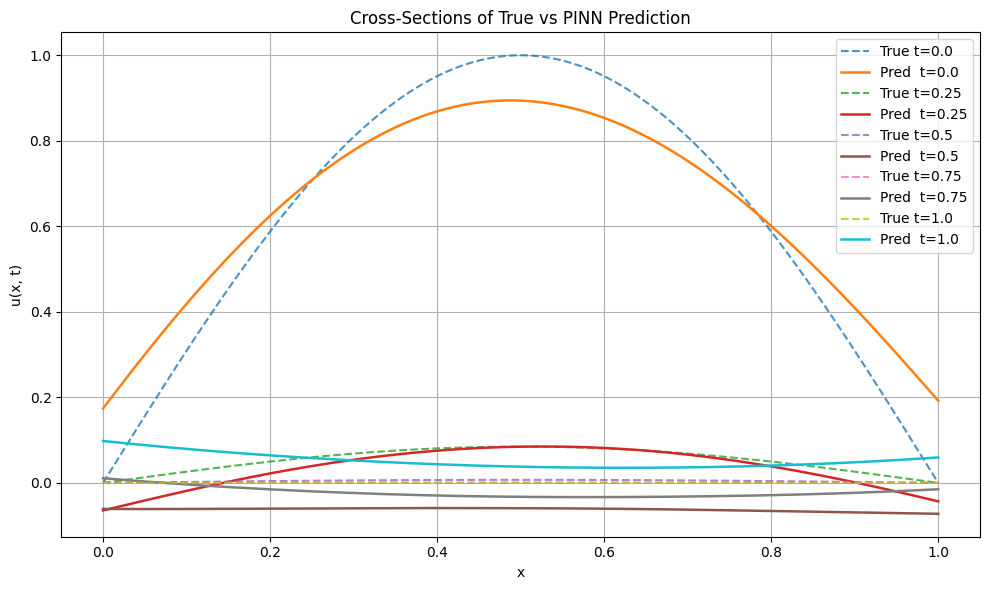

In [66]:
#cross sections
time_slices = [0.0, 0.25, 0.5, 0.75, 1.0]
x_vals = np.linspace(0, 1, 200)[:, None]

plt.figure(figsize=(10, 6))

for t in time_slices:
    t_vals = np.full_like(x_vals, t)
    xt_input = np.hstack((x_vals, t_vals))
    xt_tensor = torch.tensor(xt_input, dtype=torch.float32).to(device)

    with torch.no_grad():
        u_pred = model(xt_tensor).cpu().numpy()

    u_true = np.sin(np.pi * x_vals) * np.exp(-np.pi**2 * t)

    plt.plot(x_vals, u_true, label=f"True t={t}", linestyle="--", alpha=0.8)
    plt.plot(x_vals, u_pred, label=f"Pred  t={t}", linewidth=1.8)

plt.title("Cross-Sections of True vs PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

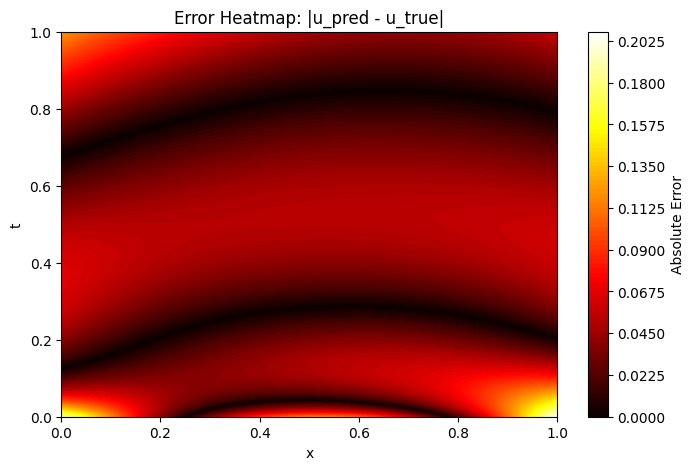

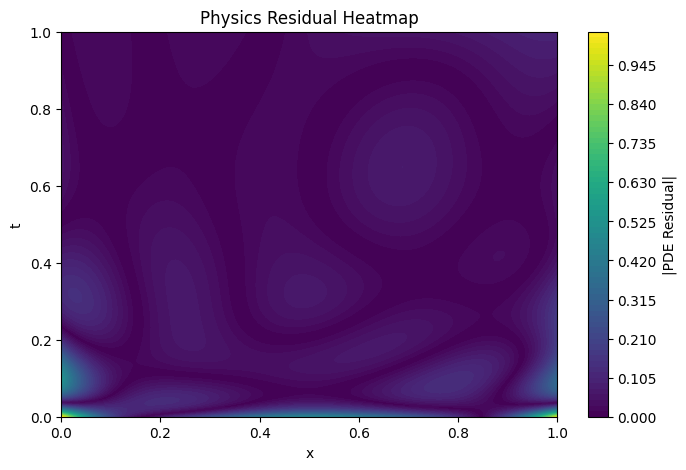

In [50]:
# 1. Generate a dense grid of test points
N_test = 200
x_test = np.linspace(0, 1, N_test)
t_test = np.linspace(0, 1, N_test)
X, T = np.meshgrid(x_test, t_test)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

# 2. Model prediction
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_test, N_test)

# 3. True solution for comparison (for 1D heat equation with u(x,0)=sin(pi x))
u_true = np.sin(np.pi * X) * np.exp(-np.pi**2 * T)

# 4. Error heatmap
plt.figure(figsize=(8, 5))
plt.contourf(X, T, np.abs(u_pred - u_true), 100, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Error Heatmap: |u_pred - u_true|")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

# 5. PDE Residual (physics loss)
XT_tensor.requires_grad_(True)
u = model(XT_tensor)

grads = torch.autograd.grad(
    u, XT_tensor,
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True
)[0]

u_x = grads[:, 0]
u_t = grads[:, 1]

u_xx = torch.autograd.grad(
    u_x, XT_tensor,
    grad_outputs=torch.ones_like(u_x),
    retain_graph=True,
    create_graph=True
)[0][:, 0]

residual = (u_t - u_xx).detach().cpu().numpy().reshape(N_test, N_test)

# 6. Residual heatmap
plt.figure(figsize=(8, 5))
plt.contourf(X, T, np.abs(residual), 100, cmap="viridis")
plt.colorbar(label="|PDE Residual|")
plt.title("Physics Residual Heatmap")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

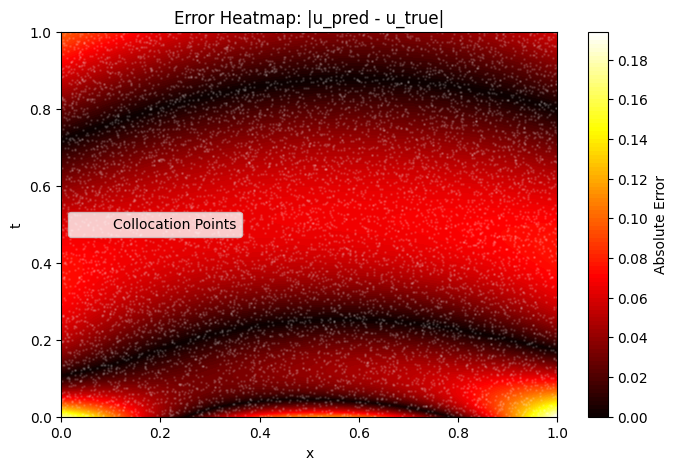

In [69]:
# 1. Generate a dense grid of test points
N_test = 200
x_test = np.linspace(0, 1, N_test)
t_test = np.linspace(0, 1, N_test)
X, T = np.meshgrid(x_test, t_test)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

# 2. Model prediction
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_test, N_test)

# 3. True solution for comparison (for 1D heat equation with u(x,0)=sin(pi x))
u_true = np.sin(np.pi * X) * np.exp(-np.pi**2 * T)


# 4. Error heatmap
plt.figure(figsize=(8, 5))
plt.contourf(X, T, np.abs(u_pred - u_true), 100, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Error Heatmap: |u_pred - u_true|")
plt.xlabel("x")
plt.ylabel("t")
plt.scatter(x_f, t_f, color='white', alpha=0.1, s=1, label="Collocation Points")
plt.legend()
plt.show()


In [71]:
#saving error info before adaptive training

# 1. Generate dense test grid
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
xx, tt = np.meshgrid(x_test, t_test)

X_star = np.hstack((xx.flatten()[:, None], tt.flatten()[:, None]))
X_star_tensor = torch.tensor(X_star, dtype=torch.float32).to(device)

# 2. Model prediction
with torch.no_grad():
    u_pred_before = model(X_star_tensor).cpu().numpy().flatten()

# 3. True solution
x_vals = X_star[:, 0]
t_vals = X_star[:, 1]
u_true_before = np.exp(-np.pi**2 * t_vals) * np.sin(np.pi * x_vals)

# 4. Compute and reshape error
original_error_abs = np.abs(u_pred_before - u_true_before).reshape(xx.shape)

In [72]:
# Adaptive sampling based on model error

# 1. Create a meshgrid over the domain
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
xx, tt = np.meshgrid(x, t)

# 2. Prepare the input coordinates for model prediction
X_star = np.column_stack((xx.ravel(), tt.ravel()))
X_star_tensor = torch.tensor(X_star, dtype=torch.float32).to(device)

# 3. Predict u(x, t) using the current model
with torch.no_grad():
    u_pred = model(X_star_tensor).cpu().numpy().flatten()

# 4. Compute true solution: u(x, t) = exp(-pi^2 * t) * sin(pi * x)
u_true = np.exp(-np.pi**2 * X_star[:, 1]) * np.sin(np.pi * X_star[:, 0])

# 5. Calculate and reshape absolute error
error_abs = np.abs(u_pred - u_true).reshape(xx.shape)

# 6. Flatten everything for filtering
x_flat = xx.ravel()
t_flat = tt.ravel()
error_flat = error_abs.ravel()

# 7. Identify top 5% highest-error regions
threshold = np.percentile(error_flat, 95)
high_error_idx = np.where(error_flat >= threshold)[0]

x_high = x_flat[high_error_idx].reshape(-1, 1)
t_high = t_flat[high_error_idx].reshape(-1, 1)

# 8. Sample new collocation points from high-error regions (safe sampling)
N_adapt = min(2000, len(x_high))
rand_idx = np.random.choice(len(x_high), size=N_adapt, replace=False)

x_adapt = x_high[rand_idx]
t_adapt = t_high[rand_idx]

In [73]:
#retrain the model

#new adaptive points
X_adapt = torch.tensor(np.hstack((x_adapt, t_adapt)), dtype=torch.float32).to(device)

#update colocation points
X_f_aug = torch.cat([X_f, X_adapt], dim=0)


In [74]:
#training loop

num_epochs = 500
mse_loss = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # 1. Predict at initial, boundary, and collocation points
    X_f_aug.requires_grad_(True)            # Make sure gradients flow from input
    u_0_pred = model(X_0)                # Initial condition
    u_b_pred = model(X_b)                # Boundary condition
    u_f_pred = model(X_f_aug)                # Collocation points

    # 2. Compute physics residual using autograd
    u_f_pred.requires_grad_(True)
    grads = torch.autograd.grad(
        u_f_pred, X_f_aug,
        grad_outputs=torch.ones_like(u_f_pred),
        create_graph=True, retain_graph=True
    )[0] #taking the first (and only) element — the gradient with respect to X_f

    u_t = grads[:, 1:2] # ∂u/∂t (column 1)
    u_x = grads[:, 0:1] # ∂u/∂x (column 0)
    u_xx = torch.autograd.grad( #second derivative
        u_x, X_f_aug,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True, retain_graph=True
    )[0][:, 0:1]

    residual = u_t - u_xx  # This is from the heat equation: u_t = u_xx, residual needs to be zero

    # 3. Compute total loss
    loss_ic = mse_loss(u_0_pred, Y_0)
    loss_bc = mse_loss(u_b_pred, Y_b)
    loss_phys = mse_loss(residual, torch.zeros_like(residual))

    loss = loss_ic + loss_bc + loss_phys #combines all three losses

    # 4. Backpropagation and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 5. Logging
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f} | IC: {loss_ic.item():.6f}, BC: {loss_bc.item():.6f}, Physics: {loss_phys.item():.6f}")

Epoch 0: Loss = 0.017704 | IC: 0.008690, BC: 0.003738, Physics: 0.005276
Epoch 100: Loss = 0.010342 | IC: 0.005060, BC: 0.002714, Physics: 0.002568
Epoch 200: Loss = 0.005304 | IC: 0.002470, BC: 0.001364, Physics: 0.001470
Epoch 300: Loss = 0.003290 | IC: 0.001222, BC: 0.000732, Physics: 0.001337
Epoch 400: Loss = 0.002047 | IC: 0.000679, BC: 0.000438, Physics: 0.000931
Epoch 499: Loss = 0.001461 | IC: 0.000409, BC: 0.000274, Physics: 0.000777


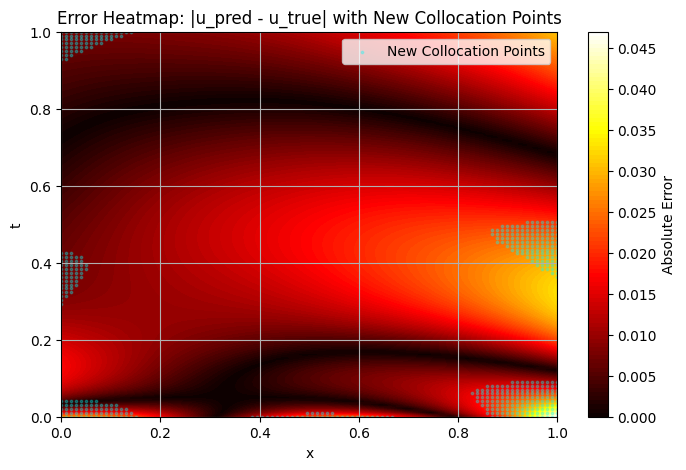

In [79]:
# 1. Generate a dense grid of test points
N_test = 100
x_test = np.linspace(0, 1, N_test)
t_test = np.linspace(0, 1, N_test)
X, T = np.meshgrid(x_test, t_test)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

# 2. Model prediction
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_test, N_test)

# 3. True solution for comparison (for 1D heat equation with u(x,0)=sin(pi x))
u_true = np.sin(np.pi * X) * np.exp(-np.pi**2 * T)

# 4. Error heatmap with new collocation points overlaid
plt.figure(figsize=(8, 5))
plt.contourf(X, T, np.abs(u_pred - u_true), 100, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Error Heatmap: |u_pred - u_true| with New Collocation Points")
plt.xlabel("x")
plt.ylabel("t")

# Overlay the new adaptive collocation points
plt.scatter(x_adapt, t_adapt, color='cyan', alpha=0.3, s=3, label="New Collocation Points")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-80-2867941738.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


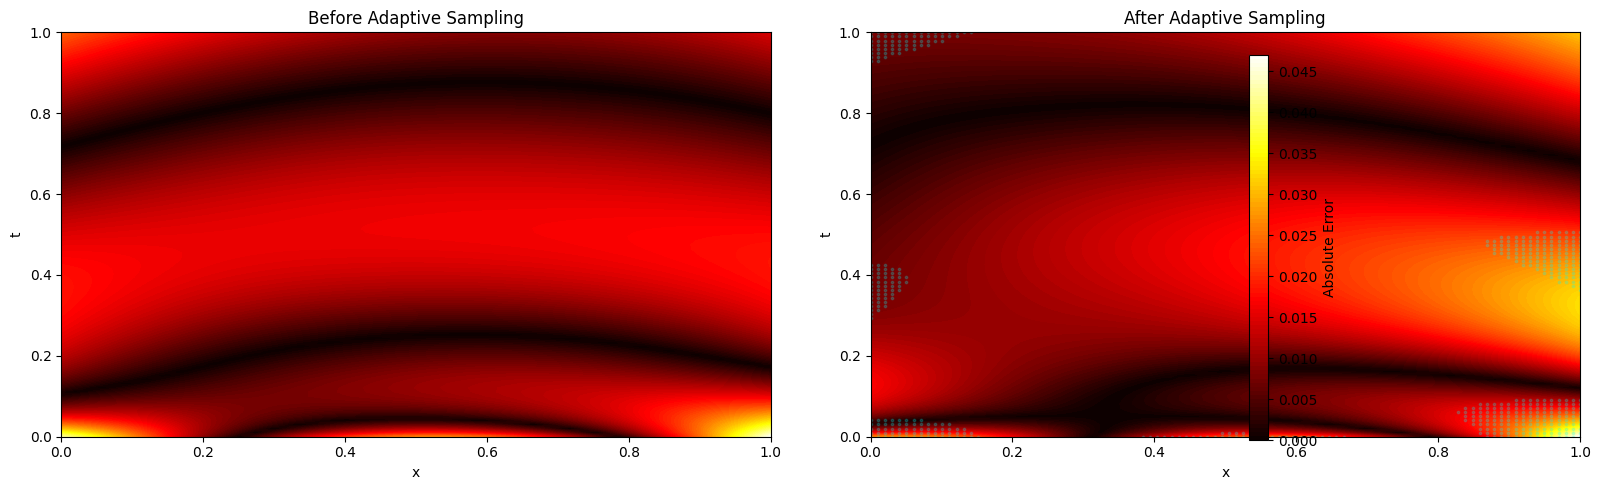

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# BEFORE adaptive sampling
axs[0].contourf(X, T, original_error_abs, 100, cmap="hot")
axs[0].set_title("Before Adaptive Sampling")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")

# AFTER adaptive sampling
axs[1].contourf(X, T, np.abs(u_pred - u_true), 100, cmap="hot")
axs[1].scatter(x_adapt, t_adapt, color='cyan', alpha=0.2, s=3)
axs[1].set_title("After Adaptive Sampling")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")

plt.colorbar(axs[1].collections[0], ax=axs, orientation='vertical', label="Absolute Error")
plt.tight_layout()
plt.show()

In [81]:
mean_error_before = np.mean(original_error_abs)
mean_error_after = np.mean(np.abs(u_pred - u_true))

max_error_before = np.max(original_error_abs)
max_error_after = np.max(np.abs(u_pred - u_true))

print(f"Mean Abs Error Before: {mean_error_before:.6f}")
print(f"Mean Abs Error After : {mean_error_after:.6f}")
print(f"Max Abs Error Before : {max_error_before:.6f}")
print(f"Max Abs Error After  : {max_error_after:.6f}")

Mean Abs Error Before: 0.040191
Mean Abs Error After : 0.010468
Max Abs Error Before : 0.192142
Max Abs Error After  : 0.046999


## 🔍 Adaptive Sampling Reflections: Did We Make It Worse?

After using error-based adaptive sampling to add more collocation points, we stepped back and asked:

### 🧠 What We Observed

- **New colocation points** mostly landed near the **boundaries**, not the high-error arcs we *hoped* to target.
- The **arcs of low error** (seen in the original heatmap) became **less evenly spaced**.
- We introduced **new error hotspots**, especially near `x = 1`.
- **Overall error may have dropped**, but **local accuracy suffered** in places.

### ⚖️ So… Is This Model Better?

> It depends.

| If we care about...                     | Then...                        |
|----------------------------------------|-------------------------------|
| Accuracy across the full domain        | The model *might* be better   |
| Accuracy near `x = 1`                  | The model is *worse* there    |
| A smooth, physical-looking solution    | The new hotspots are sus      |
| Optimizing where it matters            | We didn't quite nail that yet |

### 🤔 Takeaways

- Adaptive sampling **shifts accuracy**, but doesn’t guarantee global improvement.
- It’s not magic — it’s just targeted reinforcement.
- If you poke the model, it’ll focus where you poked… sometimes at the expense of other regions.
- “Better” is contextual. This model might be ideal for some applications — and actively harmful for others.

> “We tried to help… and possibly made it worse. But at least we learned something.”

---

